In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mimo_lib.simulate_transmission import simulate_transmission
from mimo_lib.spatial_filters import Linear, SvdFilter, DftFilter
from mimo_lib.TaskCfg import TaskCfg, load_link

In [2]:
# config parameters
t_cfg = TaskCfg(
    packet_cnt=64,  # Amount of packets for transmission (default: 32)
    sc_cnt=256,     # L Number of constellation points and allocated sub-carriers
                    # for OFDM L < K - 12*StudentID (default: 256 for BPSK)
    student_id=3
)

# axes: <time> x <sub-carrier> x <UE antenna> x <BS antenna>
chan_name = "chan_PATH"
link_channel, path_loss = load_link(t_cfg, file_name="Data/link_{}.mat".format(chan_name))
print('Channel path_loss:{:.2f}  ({:.2f} dB)'.format(path_loss, 20 * np.log10(path_loss)))

# process all the svd at once to improve performance
link_u, link_s, link_vh = np.linalg.svd(link_channel, full_matrices=False)
packet_cnt, sc_cnt, ue_ant_cnt, bs_ant_cnt = link_channel.shape

Channel path_loss:0.00  (-93.68 dB)


In [4]:
# filters to test
sp_filters = [
    Linear(enable_regularization=False),
    Linear(enable_regularization=True),
    
    SvdFilter([0]),
    SvdFilter([1]),
    #SvdFilter([2]),
    #SvdFilter([3]),
    
    #SvdFilter([0, 1]),
    #SvdFilter([0, 1, 2]),
    
    #DftFilter(1),
    #DftFilter(4),
    #DftFilter(8),
]

# dB range of SNR (default -20...8 for BPSK)
snr_list = np.linspace(-10, 15, 20)

# random data to test on
# shape <packet> - <subcarrier>
tx_OFDM = (2 * np.random.randint(0, 2, (t_cfg.packet_cnt, t_cfg.sc_cnt)) - 1)

In [5]:
# <filter> x <snr> x <packet>
ber = np.zeros((len(sp_filters), len(snr_list)))

# test reception for each filter and SNR case
for filter_ind in range(len(sp_filters)):
    print("<< Running test for '{}' >>".format(sp_filters[filter_ind].label()))

    for snr_ind in range(len(snr_list)):
        ber[filter_ind, snr_ind] = simulate_transmission(
            t_cfg,
            link_channel, link_u, link_s, link_vh,
            snr_list[snr_ind],
            tx_OFDM,
            sp_filters[filter_ind],
            use_snr_linear = False
        )

        print("\tSNR = {:.2f} dB,  \tBER = {:.2e}".format(snr_list[snr_ind], ber[filter_ind, snr_ind]))

<< Running test for 'Linear( reg=False )' >>
	SNR = -10.00 dB,  	BER = 2.45e-01
	SNR = -8.68 dB,  	BER = 2.22e-01
	SNR = -7.37 dB,  	BER = 1.78e-01
	SNR = -6.05 dB,  	BER = 1.41e-01
	SNR = -4.74 dB,  	BER = 1.08e-01
	SNR = -3.42 dB,  	BER = 8.01e-02
	SNR = -2.11 dB,  	BER = 4.51e-02
	SNR = -0.79 dB,  	BER = 2.73e-02
	SNR = 0.53 dB,  	BER = 1.25e-02
	SNR = 1.84 dB,  	BER = 5.62e-03
	SNR = 3.16 dB,  	BER = 2.01e-03
	SNR = 4.47 dB,  	BER = 4.27e-04
	SNR = 5.79 dB,  	BER = 1.22e-04
	SNR = 7.11 dB,  	BER = 0.00e+00
	SNR = 8.42 dB,  	BER = 0.00e+00
	SNR = 9.74 dB,  	BER = 0.00e+00
	SNR = 11.05 dB,  	BER = 0.00e+00
	SNR = 12.37 dB,  	BER = 0.00e+00
	SNR = 13.68 dB,  	BER = 0.00e+00
	SNR = 15.00 dB,  	BER = 0.00e+00
<< Running test for 'Linear( reg=True )' >>
	SNR = -10.00 dB,  	BER = 1.93e-01
	SNR = -8.68 dB,  	BER = 1.60e-01
	SNR = -7.37 dB,  	BER = 1.24e-01
	SNR = -6.05 dB,  	BER = 8.81e-02
	SNR = -4.74 dB,  	BER = 6.08e-02
	SNR = -3.42 dB,  	BER = 4.10e-02
	SNR = -2.11 dB,  	BER = 2.49e-02

<IPython.core.display.Javascript object>


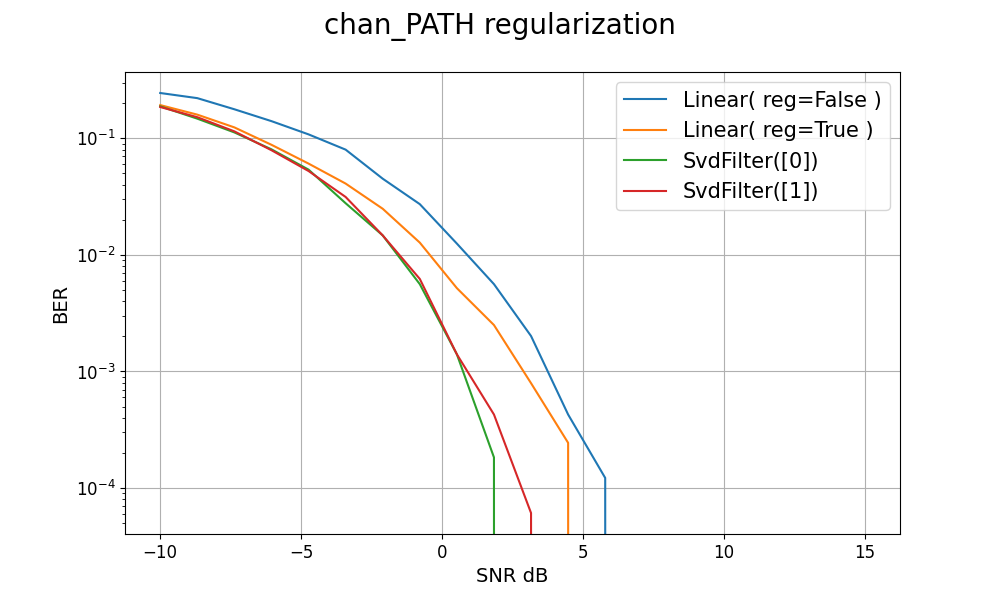

In [8]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for sp_filter_ind in range(len(sp_filters)):
    ax.semilogy(snr_list, ber[sp_filter_ind])

ax.grid(True)
ax.legend([sp_filter.label() for sp_filter in sp_filters], fontsize=15)
ax.set_xlabel("SNR dB", fontsize=14)
ax.set_ylabel("BER", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.suptitle("{}".format(chan_name), fontsize=20)

plt.savefig("output/BER_SVD_{}.jpg".format(chan_name))

In [8]:
import numpy as np
a = np.array([1, 2])
print(np.linalg.norm(a, ord=2))

2.23606797749979
